# Qiskit 8 

&nbsp;

## Contents

&nbsp;

1. [Shor's Algorithm](#sa)
2. [Quantum Counting](#qcount)
    1. [Implementation](#impl)

**Module Imports**

In [91]:
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
import qiskit
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.visualization import plot_histogram

In [92]:
# Plot results
def show_results(D):
    # D is a dictionary with classical bits as keys and count as value
    # example: D = {'000': 497, '001': 527}
    plt.bar(range(len(D)), list(D.values()), align='center')
    plt.xticks(range(len(D)), list(D.keys()))
    plt.show()

# Execute circuit, display a histogram of the results
def execute_locally(qc, draw_circuit=False):
    # Compile and run the Quantum circuit on a simulator backend
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = execute(qc, backend_sim)
    result_sim = job_sim.result()
    result_counts = result_sim.get_counts(qc)
    
    # Print the results
    print("simulation: \n\n", result_counts)
    show_results(result_counts)
    return result_counts

# 1. [Shor's Algorithm](https://raw.githubusercontent.com/qiskit-community/intro-to-quantum-computing-and-quantum-hardware/master/lectures/introqcqh-lecture-notes-4.pdf) <a id ='sa'></a>

Shor’s algorithm is famous for factoring integers in polynomial time. 

## The problem

Facturing a number $N=pq$, where $p$,$q$ are prime and large numbers.
* classically - $O (\exp[c \cdot n ^{\frac{1}{3}} (\log n )^{\frac{2}{3}}])$, using the best known methods. 
* Shor's algorithm - is a little faster than $O (n^3)$.


### Modular arithmetics

$5 / 3 \rightarrow quotient =1 ; remainder 2 $ 

$5  \equiv  2 (\mod 3)$

Generally, $x \equiv y (\mod 3)  \Rightarrow  x = 3k + y $ for some $k \in Z$

Notice the **periodicity** of modular arithmatic!

$x \equiv y (\mod N)$ means $y \in \{0,..., N\}$

## Protocol 

$$N = pq$$

1. pick a number "a" that is a coprime with $N$. ($\equiv gcd(a,N)=1$)
2. find the "order" $r$ of the function $a^r (\mod N)$. ($\equiv$ smallest $r$ such that $a^r \equiv 1 (\mod N$))
3. if $r$ is even:
 $x\equiv a^\frac{r}{2} (\mod N)$
 
 if $x+q \ne 0 (\mod N)$ then 
 
 $\{p,q\} =\{ \gcd (x+1,N) ,\gcd (x-1),N\}$
 
 else: find another "a"

## [Implemenation](https://qiskit.org/textbook/ch-algorithms/shor.html) 

We will focus on the quantum part of Shor’s algorithm, which actually solves the problem of period finding. Since a factoring problem can be turned into a period finding problem in polynomial time, an efficient period finding algorithm can be used to factor integers efficiently too. For now its enough to show that if we can compute the period of $a^x \mod N$ efficiently, then we can also efficiently factor.


Shor’s solution was to use quantum phase estimation on the unitary operator:
$$U|y\rangle \equiv |ay \mod N \rangle$$

Quantum circuit to factoring $15$.

Let "a" be $13$. 

In [93]:
a=13

In [94]:
if a not in [2,7,8,11,13]:
    raise ValueError("'a' must be 2,7,8,11 or 13")

In [95]:
n_count = 4

**Step 0** 

$15 =[1111]$ start two sets of 4 qubits

$$|x\rangle |w\rangle = |0\rangle ^{\otimes 4}|0\rangle ^{\otimes 4} $$

In [96]:
x = QuantumRegister(n_count,'x')
w = QuantumRegister(n_count,'w')
cr = ClassicalRegister(2*n_count,'c')
qc = QuantumCircuit(x,w,cr)

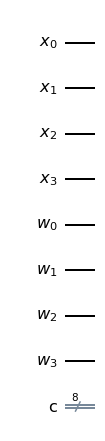

In [97]:
qc.draw(output='mpl')

**Step 1**

Perform Hadamards on the control bits.

$$[H^{\otimes 4} |0\rangle ^{\otimes 4}] |0\rangle^{\otimes 4}$$
$$\frac{1}{4} [|0\rangle_4 + |1\rangle_4 + |2\rangle_4 + ... + |15\rangle_4]|0\rangle_4$$

In [98]:
qc.h(x)

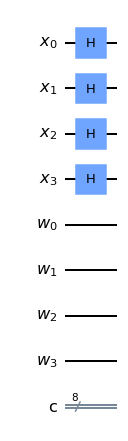

In [99]:
qc.draw(output='mpl')

**Step 2**

Apply the Control $U_{f_{a,N}}$.

$$|x\rangle |w\rangle \rightarrow |x\rangle |w \oplus f_{a,N}(x)\rangle \mbox{ where } f_{a,N}(x) \equiv a^x(\mod N)$$

$$\frac{1}{4}[|0\rangle_4 |0\oplus 13^0 (\mod 15)\rangle_4+|1\rangle_4 |0\oplus 13^1 (\mod 15)\rangle_4 + ...]$$

Since $0 \oplus Z =Z$

$$=\frac{1}{4}[|0\rangle_4|1\rangle_4 +|1\rangle_4 |13\rangle_4+|2\rangle_4|4\rangle_4 +|3\rangle_4 |7\rangle_4$$
$$ + |4\rangle_4 |1\rangle_4 + |5\rangle_4 |13\rangle_4 + |6\rangle_4 |4\rangle_4  +|7\rangle_4 |7\rangle_4 $$
$$ + |8\rangle_4 |1\rangle_4 + |9\rangle_4 |13\rangle_4 +|10\rangle_4 |4\rangle_4 + |11\rangle_4 |7\rangle_4 $$
$$ + |12\rangle_4 |1\rangle_4 + |13\rangle_4 |13\rangle_4 +|14\rangle_4 |4\rangle_4 +|15\rangle_4 |7\rangle_4 ]$$

<div class="alert alert-block alert-info">
    
**Quantum circuits as (controlled) multi-qubit gates**

&nbsp;

Notice the python function takes no input and returns a `QuantumCircuit` object with 4 qubits. In the past the functions you created might have modified an existing circuit, but a function like this allows us to turn the `QuantumCircuit` object into a single gate we can then control.

We can use `.to_gate()` and `.control()` to create a controlled gate from a circuit.

These custom gates can then be added to the circuit using the `.append(gate, qargs = [qubits])` method on the `QuantumCircuit` object.

</div>

[Tip here](https://www.semanticscholar.org/paper/Comment-on-%22Realization-of-a-scalable-Shor-Cao-Liu/edb06556b7dc87fd91137909dbe35c7106b73261/figure/0)

In [100]:
def Uf(a, power):
    U = QuantumCircuit(4)        
    for iteration in range(power):
        U.swap(0,1)
        U.swap(1,2)
        U.swap(2,3)
        U.x(0)
        U.x(1)
        U.x(2)
        U.x(3)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

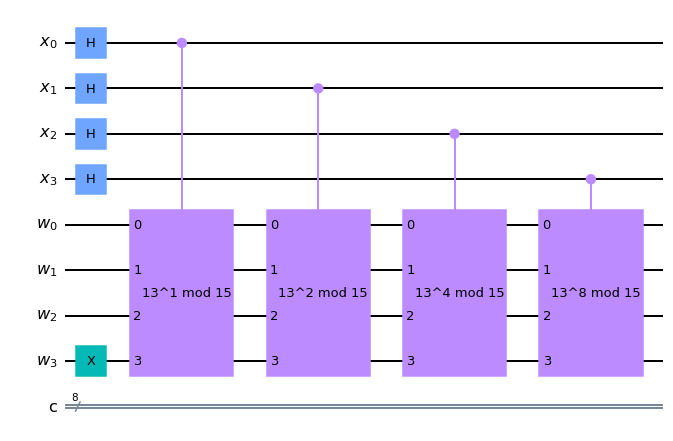

In [101]:
# And auxiliary register in state |1>
qc.x(3+n_count)

# Do controlled-U operations
for q in range(n_count):
    qc.append(Uf(a, 2**q), [q] + [i+n_count for i in range(4)])

qc.draw(output='mpl')

**Step 3** Measure the registers $w$.

Let's say we measure $7$:

$$\frac{1}{2} [|3\rangle_4 + |7\rangle_4+ |11\rangle_4 +|15\rangle_4] \otimes |7\rangle_4$$

In [102]:
qc.measure(w,cr[n_count:2*n_count])

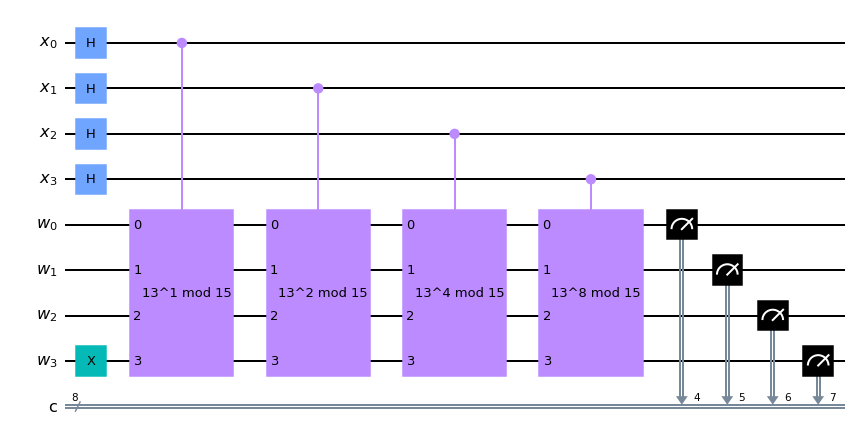

In [103]:
qc.draw(output='mpl')

**Step 4** Apply QFT$^{\dagger}$ on the register

$$QFT^{\dagger} |\tilde{x} \rangle = |x \rangle \frac{1}{\sqrt{N}}\sum^{N-1}_{y=0} e^{\frac{2 \pi i }{N} x y} | y \rangle$$

In [104]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

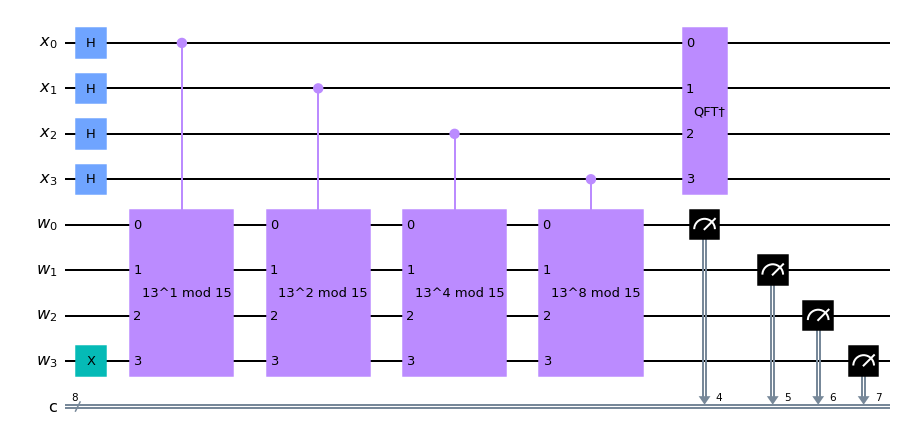

In [105]:
# Do inverse-QFT
qc.append(qft_dagger(4),x)
qc.draw(output='mpl')

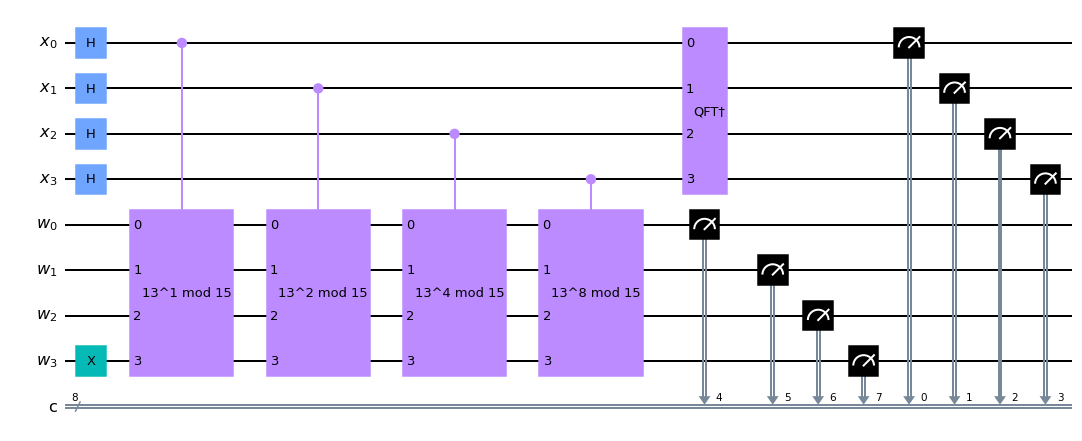

In [106]:
# Measure circuit
qc.measure(x,cr[0:n_count])
qc.draw(output='mpl')

simulation: 

 {'00101100': 72, '10110100': 61, '11101000': 60, '10001100': 59, '11100100': 59, '10111100': 71, '10111000': 67, '10110000': 57, '10000100': 67, '00100000': 58, '00100100': 71, '11100000': 70, '00101000': 64, '11101100': 64, '10001000': 62, '10000000': 62}


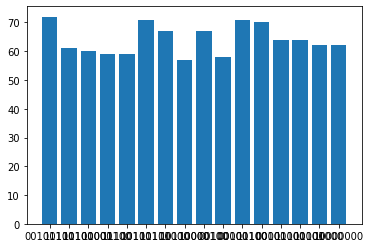

In [107]:
a = execute_locally(qc)

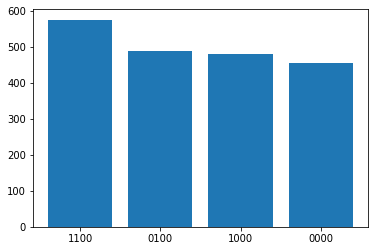

In [108]:
d = dict()
for k in a.keys():
    s = k[4:]
    if s in d:
        c = d.get(k[4:])
        d[s] = d[s]+c
    else:
        d[s]=a[k]

show_results(d)   

# 2. Quantum Counting <a id='qcount'></a>

&nbsp;

Whereas Grover’s algorithm attempts to find a solution to the Oracle, the quantum counting algorithm aims to tells us how many of these solutions there are. This algorithm is interesting as it combines both quantum search and quantum phase estimation.

&nbsp;

## The problem

&nbsp;

Consider a finite set $\{0,1\}^n$ of size $N=2^n$ and a set $B$ of "solutions" (that is a subset of $ \{0,1\}^n $). Define:

$ \begin{cases} f : \left\{0,1\right\}^n \to \{0,1\} \\ f(x) = \begin{cases} 1  & x \in B \\ 0  &  x \notin B \end{cases} \end{cases}$

In other words, $f$ is the indicator function of $B$.

Calculate the number of solutions $ M = \left\vert f^{-1}(1) \right\vert = \vert B \vert$

## Introduction

&nbsp;

In quantum counting, we simply use the quantum phase estimation algorithm to find an eigenvalue of a Grover search iteration. 

Remember that an iteration of Grover’s algorithm can be visualized as vector rotations on the $\mathbb{C}^N$ plane spanned by two statevectors: $| s \rangle$, a uniform superposition of all input states

$$| s \rangle = \frac{1}{\sqrt{N}} \sum_{x = 0}^{N -1} | x
\rangle $$

and a *marked* state $|w\rangle$, also known as the "winner".

<img src="https://qiskit.org/textbook/ch-algorithms/images/grover_list.png" width="400 px" align="center">

These statevectors are not perpendicular as $| w \rangle$ occurs in the superposition $|s\rangle$ with amplitude $N^{-1/2}$ as well. We can, however, introduce an additional state $|s'\rangle$ that is in the span of these two vectors, which is perpendicular to $| w \rangle$ and is obtained from $|s \rangle$ by removing $| w \rangle$ and rescaling. 



An iteration of Grover's algorithm $G$, rotates the state vector by $\theta$ in the $|\omega\rangle$, $|s’\rangle$ basis:

<img src="https://qiskit.org/textbook/ch-algorithms/images/quantum_counting1.svg" width="300 px" align="center">


The percentage number of solutions in our search space affects the difference between $|s\rangle$ and $|s’\rangle$. For example, if there are not many solutions, $|s\rangle$ will be very close to $|s’\rangle$ and $\theta$ will be very small. It turns out that the eigenvalues of the Grover iterator are $e^{\pm i\theta}$, and we can extract this using quantum phase estimation (QPE) to estimate the number of solutions ($M$).

## Grover's iteration as an operator

&nbsp;

In the $|\omega\rangle$,$|s’\rangle$ basis we can write the Grover iterator as the matrix:

$$
G =
\begin{pmatrix}
\cos{\theta} && -\sin{\theta}\\
\sin{\theta} && \cos{\theta}
\end{pmatrix}
$$

The matrix $G$ has eigenvectors:

$$
\begin{pmatrix}
-i\\
1
\end{pmatrix}
,
\begin{pmatrix}
i\\
1
\end{pmatrix}
$$

With the aforementioned eigenvalues $e^{\pm i\theta}$. Fortunately, we do not need to prepare our register in either of these states, the state $|s\rangle$ is in the space spanned by $|\omega\rangle$, $|s’\rangle$, and thus is a superposition of the two vectors.
$$
|s\rangle = \alpha |\omega\rangle + \beta|s'\rangle
$$

As a result, the output of the QPE algorithm will be a superposition of the two phases, and when we measure the register we will obtain one of these two values! We can then use some simple maths to get our estimate of $M$.

<img src="https://qiskit.org/textbook/ch-algorithms/images/quantum_counting2.svg" width="600 px" align="center">

Recall, from the previous class, that measured bit values $\phi_1, \cdots, \phi_n$ give an estimate of the phase $\phi \approx 0.\phi_1 \cdots \phi_n$, or $\phi \approx \frac{\phi_1}{2}+ \cdots + \frac{\phi_n}{2^n}$.


## A. Implementation <a id='impl'></a>

We choose to ‘count’ on the first 4 qubits (we call the number of counting qubits $t$, so $t = 4$), and to 'search' through the last 4 qubits ($n = 4$). Since we only care about the measurement of the counting qubits, we have initialised 4 classical bits to measure to.
With that done, we can start creating the building blocks of our circuit.

### Controlled-Grover Iteration

We have already covered Grover iterations in the Grover’s algorithm section. Here is an example with an Oracle we know has 5 solutions ($M = 5$) of 16 states ($N = 2^n = 16$), combined with a diffusion operator:

In [109]:
def example_grover_iteration():
    """Small circuit with 5/16 solutions"""
    # Do circuit
    qc = QuantumCircuit(4)
    # Oracle
    qc.h([2,3])
    qc.ccx(0,1,2)
    qc.h(2)
    qc.x(2)
    qc.ccx(0,2,3)
    qc.x(2)
    qc.h(3)
    qc.x([1,3])
    qc.h(2)
    qc.mct([0,1,3],2)
    qc.x([1,3])
    qc.h(2)
    # Diffuser
    qc.h(range(3))
    qc.x(range(3))
    qc.z(3)
    qc.mct([0,1,2],3)
    qc.x(range(3))
    qc.h(range(3))
    qc.z(3)
    return qc

We will call our Grover iterator `grit` and the controlled Grover iterator `cgrit`

In [110]:
qc = QuantumCircuit(3)

In [111]:
# Create controlled-Grover
grit = example_grover_iteration().to_gate()
cgrit = grit.control(1)

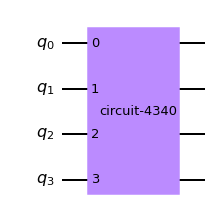

In [112]:
qr = QuantumRegister(4, 'q')
qc = QuantumCircuit(qr)
qc.append(grit, qargs=qr)
qc.draw(output='mpl')

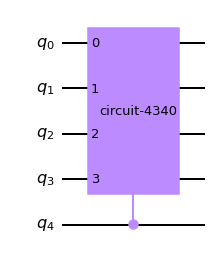

In [113]:
qr = QuantumRegister(5, 'q')
qc = QuantumCircuit(qr)
qc.append(cgrit, qargs= [qr[4]] + qr[:4])
qc.draw(output='mpl')

### Inverse QFT <a id='inv_qft'></a>
We now need to create an inverse QFT. This code implements the QFT on n qubits:

In [114]:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

<div class="alert alert-block alert-info">
    
**Inverting quantum circuits as gates**

&nbsp;

A circuit converted into a `Gate` object can be inverted by adding the `.inverse()` method.

</div>


In [115]:
def qft_dagger(count):
    return qft(count).to_gate().inverse()

### Putting it Together 

&nbsp;

<div class="alert alert-block alert-warning">
    
**Exercise 1**

&nbsp;

<img src="https://qiskit.org/textbook/ch-algorithms/images/quantum_counting2.svg" width="600 px" align="center">


1. Apply the quantum counting algorithm represented above, for `t=4` counting qubits, and `n=4` *searching* bits. What are the results after simulation?

</div>



In [126]:
t = 4
n = 4
x = QuantumRegister(t,'x')
w = QuantumRegister(n,'w')
cr =ClassicalRegister(t+n,'c')
qc = QuantumCircuit(x,w,cr)

qc.h(x)
qc.h(w)
iterations = 1
for i in range(t):
    qc.append(cgrit.repeat(iterations),qargs = [x[i]]+w[:4])
    iterations *=2

qc.append(qft_dagger(4),x)
qc.measure(x,cr[0:t])


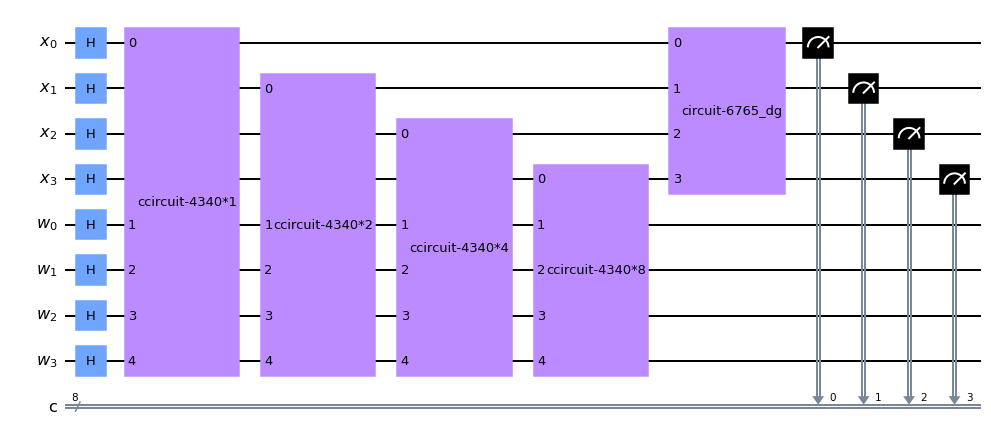

In [127]:
# Check circuit
qc.draw(output='mpl')

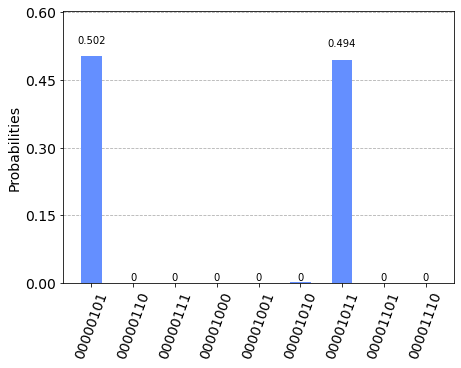

In [138]:
# Simulate circuit
simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=2048 )
hist = job.result().get_counts()
plot_histogram(hist)

We can see two values stand out, having a much higher probability of measurement than the rest. These two values correspond to $e^{i\theta}$ and $e^{-i\theta}$, but we can’t see the number of solutions yet. We need to little more processing to get this information, so first let us get our output into something we can work with (an `int`).

Get the string of the most probable result from our output data:

In [139]:
measured_str = max(hist, key=hist.get)

Store this as an integer:

In [140]:
measured_int = int(measured_str,2)
print("Register Output = %i" % measured_int)

Register Output = 5


### Finding the Number of Solutions (M)

<div class="alert alert-block alert-warning">
    
**Exercise 2**

&nbsp;

1. Create a function, `calculate_M(integ, t, n)` that takes as input the decimal integer output of our register, the number of counting qubits ($t$) and the number of searching qubits ($n$); and returns the numer of solutions `M`.

</div>

**Tips:**

* First we want to get $\theta$ from `measured_int`. Remember that QPE gives us a measured $\text{value} = 2^n \phi$ from the eigenvalue $e^{2\pi i\phi}$, so to get $\theta$ we need to do:

$$ \theta = value \times \frac{2 \pi}{2^t} $$


* We can get the angle $\theta/2$ can from the inner product of $|s\rangle$ and $|s’\rangle$:

$$
\langle s'|s\rangle = \cos{\tfrac{\theta}{2}}
$$

And that the inner product of these vectors is:

$$
\langle s'|s\rangle = \sqrt{\frac{N-M}{N}}
$$

We can combine these equations, then use some trigonometry and algebra to show:

$$
N\sin^2{\frac{\theta}{2}} = M
$$

In [145]:
def calculate_M(integ,t,n):
    theta = integ* (2*np.pi) / (2**t)
    M = (2**n)*(np.sin(theta/2)**2)
    return M

In [146]:
t = 4
n = 4
N = 2**n

N - int(calculate_M(measured_int, t, n))

5


<div class="alert alert-block alert-warning">
    
**Exercise 3**

1.	Can you adapt the circuit to use more or less counting qubits to get a different precision in your result?

</div>

In [155]:
def qcount(count):
    t = count
    n = 4
    x = QuantumRegister(t,'x')
    w = QuantumRegister(n,'w')
    cr =ClassicalRegister(t,'c')
    qc = QuantumCircuit(x,w,cr)

    qc.h(x)
    qc.h(w)
    iterations = 1
    for i in range(t):
        qc.append(cgrit.repeat(iterations),qargs = [x[i]]+w[:n])
        iterations *=2

    qc.append(qft_dagger(t),x)
    qc.measure(x,cr[0:t])

    return qc

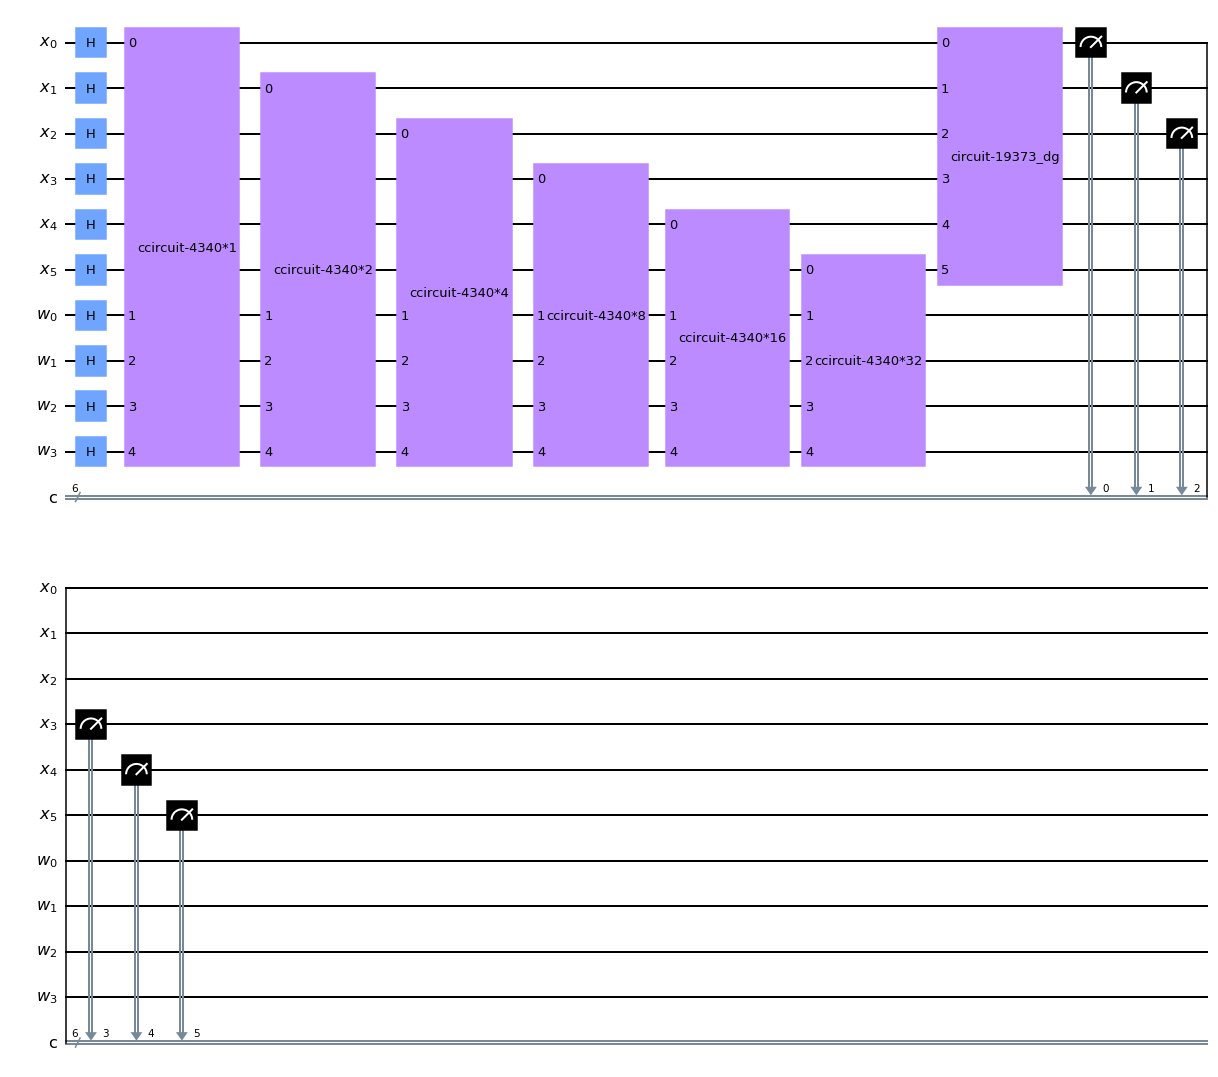

In [156]:
qcount(6).draw(output='mpl')